# Blogs to read:
* [Customer Lifetime Value Part 1: Estimating Customer Lifetimes](https://www.databricks.com/blog/2020/06/03/customer-lifetime-value-part-1-estimating-customer-lifetimes.html)
* [Customer Lifetime Value Part 2: Estimating Future Spend](https://www.databricks.com/blog/2020/06/17/customer-lifetime-value-part-2-estimating-future-spend.html)

# Introduction
In non-subscription retail models, customers come and go with no long-term commitments, making it very difficult to determine whether a customer will return in the future. In addition, customers frequently settle into a pattern of regular spend with retailers with whom they maintain a long-term relationship. But occasionally, customers will spend at higher rates before returning back to their previous norm. Both of these patterns make effective projections of customer spending very challenging for most retail organizations.

The Buy 'til You Die (BTYD) models popularized by Peter Fader and others leverage a few basic customer metrics, i.e. the recency of a customer's last engagement, the frequency of repeat transactions over a customer's lifetime, the average monetary spend associated with those transactions, and the length (term) of a customer's time engaged with a retailer to derive probabilistic estimations of both a customer's future spend and that customer's likelihood to remain engaged. Using these values, we can project likely future spend, a value we frequently refer to as the customer's lifetime value (CLV).

The math behind this approach is fairly complex but thankfully it's been encapsulated in the [btyd](https://pypi.org/project/btyd/) library, making it much easier for traditional enterprises to employ. The purpose of this notebook is to examine how these models may be applied to customer transaction history to estimate CLV.

In this notebook, we are going to create two models that are used to estimate lifetime value. The first of these will be used to estimate the probability of customer retention through a certain point in time. The second will be used to calculate the estimated monetary value through that same point in time. Together, these estimates can be combined to calculate a customer's value through and extended period of time.

In [1]:
%pip install lifetimes

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 12.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... - \ done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492022 sha256=d63e0038a8419af825792c04f29e00d96f5b1102b342e54028e24eb3d01d5aa3
  Stored in directory: /home/trusted-service-user/.cache/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: /nfs4/pyenv-e91a20ea-796e-4675-8edd-9bfab5d5e924/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install Required Libraries
%pip install btyd
%pip install openpyxl==3.1.2
# dbutils.library.restartPython()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 14, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.5/594.5 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.2/590.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.3/994.3 kB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 19.1 MB/s eta 0:0

In [3]:
# Import Required Libraries
import pandas as pd
import numpy as np
from datetime import timedelta
 
import btyd
from btyd.fitters.beta_geo_fitter import BetaGeoFitter
from btyd import GammaGammaFitter
 
from btyd.plotting import plot_calibration_purchases_vs_holdout_purchases
from btyd.plotting import plot_probability_alive_matrix
from btyd.plotting import plot_frequency_recency_matrix
 
import matplotlib.pyplot as plt
 
import pyspark.sql.functions as fn
from pyspark.sql.types import *
 
import mlflow.pyfunc
import mlflow

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 16, Finished, Available)

### Step 1: Access the Data
The dataset we will use for this exercise is the [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/Online+Retail) available from the UCI Machine Learning Repository:

In [15]:
%%sh
# here if have given just normal file path but it is possible the this task will run with 'abfss://' path

# Download Data Set
rm -rf Files/online_retail # dropping any old copies of data
mkdir -p Files/online_retail # ensuring the desination folder exists
# donwloading data to the destination folder
wget -N http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -P Files/online_retail

StatementMeta(, 883038ce-4a07-4664-b84e-8ee6dc11e747, 26, Finished, Available)

--2023-06-14 05:53:52--  http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Files/online_retail/Online Retail.xlsx’

     0K .......... .......... .......... .......... .......... 97.4K
    50K .......... .......... .......... .......... ..........  187K
   100K .......... .......... .......... .......... ..........  303M
   150K .......... .......... .......... .......... ..........  198K
   200K .......... .......... .......... .......... ..........  152M
   250K .......... .......... .......... .......... ..........  307M
   300K .......... .......... .......... .......... ..........  200K
   350K .......... .......... .......... .......... .......... 41.4M
   400K .......... .......... .......... .......... ........

In [4]:
# Reading Data
# xlsx_filename = 'Files/online_retail/Online Retail.xlsx'
xlsx_filename = 'abfss://f7a2eb39-d18b-4f3c-8fc3-db8793d2497e@onelake.dfs.fabric.microsoft.com/8f222967-5183-4e01-a5d7-886069878aff/Files/online_retail/Online Retail.xlsx'

# schema of the excel spreadsheet data range
orders_schema = {
  'InvoiceNo':str,
  'StockCode':str,
  'Description':str,
  'Quantity':np.int64,
  'InvoiceDate':np.datetime64,
  'UnitPrice':np.float64,
  'CustomerID':str,
  'Country':str  
  }

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 17, Finished, Available)

In [5]:
# read spreadsheet to pandas dataframe
# the xlrd library must be isntalled for this step to work
orders_pd = pd.read_excel(
  xlsx_filename, 
  sheet_name='Online Retail',
  header=0, # first row is header
  dtype=orders_schema
  )

# calculate sales amount as quantity * unit price
orders_pd['SalesAmount'] = orders_pd['Quantity'] * orders_pd['UnitPrice']

# display first few rows from the dataset
orders_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 18, Finished, Available)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08


The data in the workbook are organized as a range in the Online Retail spreadsheet. Each record represents a line item in a sales transaction. The fields included in the dataset are:

* **InvoiceNo:**	A 6-digit integral number uniquely assigned to each transaction
* **StockCode:**	A 5-digit integral number uniquely assigned to each distinct product
* **Description:**	The product (item) name
* **Quantity:**	The quantities of each product (item) per transaction
* **InvoiceDate:**	The invoice date and a time in mm/dd/yy hh:mm format
* **UnitPrice:**	The per-unit product price in pound sterling (£)
* **CustomerID:**	A 5-digit integral number uniquely assigned to each customer
* **Country:**	The name of the country where each customer resides
* **SalesAmount:**	Derived as Quantity * UnitPrice
Of these fields, the ones of particular interest for our work are InvoiceNo which identifies the transaction, InvoiceDate which identifies the date of that transaction, and CustomerID which uniquely identifies the customer across multiple transactions. The SalesAmount field is derived from the Quantity and UnitPrice fields in order to provide as a monetary amount around which we can estimate value.

### Step 2: Explore the Dataset
In a real-world scenario, our customer data will often be much larger than what could fit into a pandas dataframe, let alone an Excel spreadsheet. These data will typically be loaded into our lakehouse environment and made accessible as a queriable table which we can interact with using the distributed resources of our Spark environment. To simulate this, we'll go ahead and convert our pandas dataframe to a Spark dataframe and then to a queriable though temporary view:

In [6]:
# Convert Dataframe to View

# convert pandas DF to Spark DF
orders = spark.createDataFrame(orders_pd)
# present Spark DF as queryable view
orders.createOrReplaceTempView('orders')

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 19, Finished, Available)

To get started, let's take a look at the typical purchase frequency pattern and daily spend of a customer. We will group this at a daily level so that multiple purchases occuring on the same day will be treated as a single purchase event. (This is a typical pattern employed in most CLV estimations.)

#### Examine Daily Transactions

In [7]:
%%sql
-- unique transactions and daily sales by date
SELECT
    CustomerID,
    to_date(InvoiceDate) as InvoiceDate,
    count(DISTINCT InvoiceNo) as Transactions,
    sum(SalesAmount) as SalesAmount
FROM orders
GROUP BY CustomerID, to_date(InvoiceDate)
ORDER BY CustomerID, InvoiceDate

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 20, Finished, Available)

<Spark SQL result set with 1000 rows and 4 fields>

The range of daily spend is quite wide with a few customers purchasing over £70,000 in a single day. Without much knowledge of the underlying business, it's hard to say if this is level of spending is consistent with the expectations of the site. Still, it seems pretty clear that those are anomalous transactions and should be removed from our calculations.

There are also transactions with NULL Customer ID which most likely indicates data quality issue. We will remove these data now:

#### Clenaing the Dataset

In [8]:
# identify outlier customers
customers_to_exclude = (
  orders
    .groupBy('customerid','invoicedate')
      .agg(fn.sum('salesamount').alias('salesamount'))
    .filter('salesamount=70000')
    .select('customerid')
    .distinct()
  )

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 21, Finished, Available)

In [9]:
# remove bad records and outlier customers
cleansed_orders = (
  orders
    .filter('customerid is not null')
    .join(
      customers_to_exclude,
      on='customerid',
      how='leftanti'
    )
  )

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 22, Finished, Available)

In [10]:
# reload orders pandas dataframe from cleansed data
orders_pd = cleansed_orders.toPandas()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 23, Finished, Available)

In [11]:
# make cleansed data accessible for queries
_ = cleansed_orders.createOrReplaceTempView('orders')
display(spark.table('orders'))

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 24, Finished, Available)

SynapseWidget(Synapse.DataFrame, 21431134-47b7-49a2-8969-42e92e66df34)

Examining the daily transaction activity in our dataset, we can see the first transaction occurs December 1, 2010 and the last is on December 9, 2011 making this a dataset that's a little more than 1 year in duration. The daily transaction count shows there is quite a bit of volatility in daily activity for this online retailer. We can smooth this out a bit by summarizing activity by month. It's important to keep in mind that December 2011 only has 9 days worth of data which will make that

#### Examinging Transactions by Month

In [12]:
%%sql 
-- unique transactions by month
SELECT
    trunc(InvoiceDate, 'month') as InvoiceMonth,
    count(DISTINCT InvoiceNo) as Transactions,
    sum(SalesAmount) as SalesAmount
FROM orders
GROUP BY trunc(InvoiceDate, 'month')
ORDER BY InvoiceMonth;

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 25, Finished, Available)

<Spark SQL result set with 13 rows and 3 fields>

For the little more than 1-year period for which we have data, we see over four-thousand unique customers (excluding customers with NULL IDs). These customers generated about twenty-two thousand unique transactions amounting to a total of 8 million pounds:

#### Examine Summary Metrics

In [13]:
%%sql
-- unique customers and transactions

SELECT
 COUNT(DISTINCT CustomerID) as Customers,
 COUNT(DISTINCT InvoiceNo) as Transactions,
 SUM(SalesAmount) as SalesAmount
FROM orders
WHERE CustomerID IS NOT NULL and InvoiceDate<'2011-12-01';

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 26, Finished, Available)

<Spark SQL result set with 1 rows and 3 fields>

A little quick math may lead us to estimate that, on average, each customer is responsible for about 5 transactions with a total of 2000 pounds, but this would not provide an accurate representation of customer activity. For a better understanding let's look at the distribution for transaction frequency and customer spend respectively. We will combine transactions that occur on the same date to be consistent with how the BTYD models typically explore these kinds of data:

#### Examine Distribution of Per-Customer Purchase Date Counts

In [14]:
%%sql
-- the distirbution of per-customer transaction counts
-- with consideration of same-day transactions as a single transaction

SELECT
  x.Transactions,
  COUNT(x.*) as Occurrences
FROM (
  SELECT
    CustomerID,
    COUNT(DISTINCT TO_DATE(InvoiceDate)) as Transactions
  FROM orders
  GROUP BY CustomerID
  ) x
GROUP BY 
  x.Transactions
ORDER BY
  x.Transactions;

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 27, Finished, Available)

<Spark SQL result set with 57 rows and 2 fields>

What we can see in this data is that frequency tends to what we might describe as a negative binomial distribution where there is rapidly declining frequency values as we move from left to right along the x-axis.

Focusing on customers with repeat purchases, we can examine the distribution of the days between purchase events. What's important to note here is that most customers return to the site within 2 to 3 months of a prior purchase. Longer gaps do occur but significantly fewer customers have longer gaps between returns. This is important to understand in the context of our BYTD models in that the time since we last saw a customer is a critical factor to determining whether they will ever come back with the probability of return dropping as more and more time passes since a customer's last purchase event:

#### Examine Avg Number Days between Purchase Dates

In [15]:
 %%sql
-- distribution of per-customer average number of days between purchase events
WITH CustomerPurchaseDates
  AS (
    SELECT DISTINCT
      CustomerID,
      TO_DATE(InvoiceDate) as InvoiceDate
    FROM orders 
    )
SELECT -- Per-Customer Average Days Between Purchase Events
  AVG(
    DATEDIFF(a.NextInvoiceDate, a.InvoiceDate)
    ) as AvgDaysBetween
FROM ( -- Purchase Event and Next Purchase Event by Customer
  SELECT 
    x.CustomerID,
    x.InvoiceDate,
    MIN(y.InvoiceDate) as NextInvoiceDate
  FROM CustomerPurchaseDates x
  INNER JOIN CustomerPurchaseDates y
    ON x.CustomerID=y.CustomerID AND x.InvoiceDate < y.InvoiceDate
  GROUP BY 
    x.CustomerID,
    x.InvoiceDate
    ) a
GROUP BY CustomerID

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 28, Finished, Available)

<Spark SQL result set with 1000 rows and 1 fields>

Let's look at the distirbution of the spend amounts we are seeing in these data:

#### Examine Sales Distribution

In [16]:
%%sql
-- daily sales by customers (for sales sales betwene 0 and 2500 pounds)
SELECT
    CustomerID,
    to_date(InvoiceDate) as InvoiceDate,
    sum(SalesAmount) as SalesAmount
FROM orders
GROUP BY CustomerID, to_Date(InvoiceDate)
HAVING SalesAmount BETWEEN 0 AND 2500;

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 29, Finished, Available)

<Spark SQL result set with 1000 rows and 3 fields>

The distribution of daily spend in this narrowed range is centered around 200 to 400 pound sterling with a long-tail towards higher ranges of spend. It's clear this is not a normal (gaussian) distribution.

This awareness of how spend and frequency both adhere to distributions that rapidly decline from left to right is important to understanding how the BTYD models think about the data inputs we'll provide them. More on that later.

# Step 3: Calculate Customer Metrics
The dataset with which we are working consists of raw transactional history. To apply the BTYD models, we need to derive several per-customer metrics:

* **Frequency** - the number of dates on which a customer made a purchase subsequent to the date of the customer's first purchase
* **Age (Term)** - the number of time units, e.g. days, since the date of a customer's first purchase to the current date (or last date in the dataset)
* **Recency** - the age of the customer (as previously defined) at the time of their last purchase
* **Monetary Value** - the average per transaction-date spend by a customer during repeat purchases. (Margin and other monetary values may also be used if available.)
It's important to note that when calculating metrics such as customer age that we need to consider when our dataset terminates. Calculating these metrics relative to today's date can lead to erroneous results. Given this, we will identify the last date in the dataset and define that as today's date for all calculations.

To get started with these calculations, let's take a look at how they are performed using the built-in functionality of the [btyd](https://btyd.readthedocs.io/en/latest/User%20Guide.html) library:

In [17]:
# USE THE BTYD LIBRARY TO CALCULATE METRICS

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()
current_date

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 30, Finished, Available)

Timestamp('2011-12-09 12:50:00')

In [18]:
# calculate the required customer metrics
metrics_pd = (
  btyd.utils.summary_data_from_transaction_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date, 
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 31, Finished, Available)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
12352,6.0,260.0,296.0,208.151667
12353,0.0,0.0,204.0,0.000000
12354,0.0,0.0,232.0,0.000000
12355,0.0,0.0,214.0,0.000000


The btyd library, like many Python libraries, is single-threaded. Using this library to derive customer metrics on larger transactional datasets may overwhelm your system or simply take too long to complete. For this reason, let's examine how these metrics can be calculated using the distributed capabilities of Apache Spark.

In the following cells we are going to use Programmatic Spark SQL API which may align better with some Data Scientist's preferences for complex data manipulation. Of course, you can derive the same results with Spark SQL using a SQL statement. In the code in the next cell, we first assemble each customer's order history consisting of the customer's ID, the date of their first purchase (first_at), the date on which a purchase was observed (transaction_at) and the current date (using the last date in the dataset for this value). From this history, we can count the number of repeat transaction dates (frequency), the days between the last and first transaction dates (recency), the days between the current date and first transaction (T) and the associated monetary value (monetary_value) on a per-customer basis:

In [19]:
# USING PYSPARK SQL API TO CALCUALTE METRICS

# programmatic sql api calls to derive summary customer stats
# valid customer orders
x = (
    orders
      .withColumn('transaction_at', fn.to_date('invoicedate'))
      .groupBy('customerid', 'transaction_at')
      .agg(fn.sum('salesamount').alias('salesamount'))   # SALES AMOUNT
    )
display(x)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 32, Finished, Available)

SynapseWidget(Synapse.DataFrame, d1404d45-52ae-4606-a0e8-7fa5dfd3eed8)

In [20]:
# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(fn.max(fn.to_date('invoicedate')).alias('current_dt'))
  )
display(y)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 33, Finished, Available)

SynapseWidget(Synapse.DataFrame, 750667f4-1e77-43b4-a743-b1507ad002f5)

In [21]:
# calculate first transaction date by customer
z = (
  orders
    .groupBy('customerid')
    .agg(fn.min(fn.to_date('invoicedate')).alias('first_at'))
  )
display(z)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 34, Finished, Available)

SynapseWidget(Synapse.DataFrame, 6624498c-1853-4027-995e-0987b1d0f7a2)

In [22]:
# combine customer history with date info 
a = (x
    .crossJoin(y)
    .join(z, on='customerid', how='inner')
    .selectExpr(
      'customerid', 
      'first_at', 
      'transaction_at',
      'salesamount',
      'current_dt'
      )
    )
display(a)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 35, Finished, Available)

SynapseWidget(Synapse.DataFrame, f22038fa-ccbd-4842-9f73-6d2720b228b7)

In [23]:
# calculate relevant metrics by customer
metrics_api = (a
           .groupBy(a.customerid, a.current_dt, a.first_at)
           .agg(
             (
              fn.countDistinct(a.transaction_at)-1).cast(FloatType()).alias('frequency'),
              fn.datediff(fn.max(a.transaction_at), a.first_at).cast(FloatType()).alias('recency'),
              fn.datediff(a.current_dt, a.first_at).cast(FloatType()).alias('T'),
              fn.when(fn.countDistinct(a.transaction_at)==1,0)                           # MONETARY VALUE
                .otherwise(
                  fn.sum(
                    fn.when(a.first_at==a.transaction_at,0)
                      .otherwise(a.salesamount)
                    )/(fn.countDistinct(a.transaction_at)-1)
                 ).alias('monetary_value')
               )
           .select('customerid','frequency','recency','T','monetary_value')
           .orderBy('customerid')
          )
display(metrics_api )

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 36, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3039f37b-9dc8-4730-af52-d684f44727de)

Let's take a moment to compare the data in these different metrics datasets, just to confirm the results are identical. Instead of doing this record by record, let's calculate summary statistics across each dataset to verify their consistency:

NOTE You may notice means and standard deviations vary slightly in the hundred-thousandths and millionths decimal places. This is a result of slight differences in data types between the pandas and Spark dataframes but do not affect our results in a meaningful way.

In [24]:
# SUMMARY METRICS FOR LIBRARY-DERIVED VALUES
# summary data form btyd
metrics_pd.describe()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 37, Finished, Available)

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,213.254316
std,6.674343,133.000474,118.384168,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


In [25]:
# SUMMARY METRICS FOR SPARK-DERIVED VALUES
# summary data from pyspark.sql API
metrics_api.toPandas().describe()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 38, Finished, Available)

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723007,225.304214,213.254316
std,6.674344,133.000473,118.384171,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538


The metrics we've calculated represent summaries of a whole time series of data. To support model validation and avoid overfitting, a common pattern with time series data is to train models on an earlier portion of the time series (known as the calibration period) and validate against a later portion of the time series (known as the holdout period). In the btyd library, the derivation of per customer metrics using calibration and holdout periods is done through a simple method call. Because our dataset consists of a limited range for data, we will instruct this library method to use the last 90-days of data as the holdout period. A simple parameter called a widget on the Databricks platform has been implemented to make the configuration of this setting easily changeable:

In [26]:
# DEFINE HOLDOUT DAYS
holdout_days = 90

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 39, Finished, Available)

In [27]:
# USE THE BTYD LIBRARY TO CALCULATE METRICS WITH HOLDOUT

# set the last transaction date as the end point for this historical dataset
current_date = orders_pd['InvoiceDate'].max()

# dfine end of calibration period
calibration_end_date = current_date - timedelta(days = holdout_days)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 40, Finished, Available)

In [28]:
# calculate the required customer metrics
metrics_cal_pd = (
  btyd.utils.calibration_and_holdout_data(
    orders_pd,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D',
    monetary_value_col='SalesAmount'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_cal_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 41, Finished, Available)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,235.0,0.0000,0.0,0.000000,90.0
12347,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0
12348,2.0,110.0,268.0,297.2200,1.0,103.333333,90.0
12350,0.0,0.0,220.0,0.0000,0.0,0.000000,90.0
12352,3.0,34.0,206.0,101.5600,3.0,20.090000,90.0
12353,0.0,0.0,114.0,0.0000,0.0,0.000000,90.0
12354,0.0,0.0,142.0,0.0000,0.0,0.000000,90.0
12355,0.0,0.0,124.0,0.0000,0.0,0.000000,90.0
12356,1.0,80.0,235.0,481.4600,1.0,29.175000,90.0


As before, we are going to use the programmatic SQL API to derive this same information:

In [29]:
# USE PYSPARK SQL API TO CALCULATE METRICS WITH HOLDOUT

# valid customer orders
x = (
  orders
    .withColumn('transaction_at', fn.to_date('invoicedate'))
    .groupBy('customerid', 'transaction_at')
    .agg(fn.sum('salesamount').alias('salesamount'))
  )
display(x)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 42, Finished, Available)

SynapseWidget(Synapse.DataFrame, 69366fcf-e18a-4f34-b542-2c814b88b933)

In [30]:
# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(fn.max(fn.to_date('invoicedate')).alias('current_dt'))
  )
display(y)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 43, Finished, Available)

SynapseWidget(Synapse.DataFrame, 92a17c3e-888f-4c23-8696-39e2481d9bc0)

In [31]:
# calculate first transaction date by customer
z = (
  orders
    .groupBy('customerid')
    .agg(fn.min(fn.to_date('invoicedate')).alias('first_at'))
  )
display(z)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 44, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5da9a90d-3e08-4f91-b9d8-c7b6412227aa)

In [32]:
# combine customer history with date info (CUSTOMER HISTORY)
p = (x
    .crossJoin(y)
    .join(z, on='customerid', how='inner')
    .withColumn('duration_holdout', fn.lit(holdout_days))
    .select(
      'customerid',
      'first_at',
      'transaction_at',
      'current_dt',
      'salesamount',
      'duration_holdout'
      )
     .distinct()
    ) 
display(p)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 45, Finished, Available)

SynapseWidget(Synapse.DataFrame, 73897daa-66f4-4063-8caa-a00ed9312c78)

In [33]:
# calculate relevant metrics by customer
# note: date_sub requires a single integer value unless employed within an expr() call
a = (p
       .where(p.transaction_at < fn.expr('date_sub(current_dt, duration_holdout)')) 
       .groupBy(p.customerid, p.current_dt, p.duration_holdout, p.first_at)
       .agg(
         (fn.countDistinct(p.transaction_at)-1).cast(FloatType()).alias('frequency_cal'),
         fn.datediff( fn.max(p.transaction_at), p.first_at).cast(FloatType()).alias('recency_cal'),
         fn.datediff( fn.expr('date_sub(current_dt, duration_holdout)'), p.first_at).cast(FloatType()).alias('T_cal'),
         fn.when(fn.countDistinct(p.transaction_at)==1,0)
           .otherwise(
             fn.sum(
               fn.when(p.first_at==p.transaction_at,0)
                 .otherwise(p.salesamount)
               )/(fn.countDistinct(p.transaction_at)-1)
             ).alias('monetary_value_cal')
       )
    )

b = (p
      .where((p.transaction_at >= fn.expr('date_sub(current_dt, duration_holdout)')) & (p.transaction_at <= p.current_dt) )
      .groupBy(p.customerid)
      .agg(
        fn.countDistinct(p.transaction_at).cast(FloatType()).alias('frequency_holdout'),
        fn.avg(p.salesamount).alias('monetary_value_holdout')
        )
   )

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 46, Finished, Available)

In [34]:
metrics_cal_api = (
                 a
                 .join(b, on='customerid', how='left')
                 .select(
                   'customerid',
                   'frequency_cal',
                   'recency_cal',
                   'T_cal',
                   'monetary_value_cal',
                   fn.coalesce(b.frequency_holdout, fn.lit(0.0)).alias('frequency_holdout'),
                   fn.coalesce(b.monetary_value_holdout, fn.lit(0.0)).alias('monetary_value_holdout'),
                   'duration_holdout'
                   )
                 .orderBy('customerid')
              )
display(metrics_cal_api)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 47, Finished, Available)

SynapseWidget(Synapse.DataFrame, bbc1c8bd-ca0e-4a66-8542-43bf752a1704)

Using summary stats, we can again verify these different units of logic are returning the same results:

In [35]:
# Summary Metrics for Library-derived Values
# summary data from btyd
metrics_cal_pd.describe()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 48, Finished, Available)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587046,185.041618,190.242725,1.502345,17.999563,90.0
std,5.222838,96.077761,80.771943,362.064653,2.495318,77.381388,0.0
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-114.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,111.000000,1.000000,6.286336,90.0
75%,3.000000,175.000000,268.000000,276.768000,2.000000,19.131176,90.0
max,93.000000,282.000000,283.000000,7860.345833,52.000000,2685.000000,90.0


In [36]:
# Summary Metrics for Spark-derived Values
# summary data from pyspark.sql API
metrics_cal_api.toPandas().describe()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 49, Finished, Available)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587044,185.041611,190.242725,1.502345,236.965305,90.0
std,5.222837,96.077766,80.771942,362.064653,2.495318,472.652180,0.0
min,0.000000,0.000000,1.000000,-1462.500000,0.000000,-468.320000,90.0
25%,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,111.000000,1.000000,126.677500,90.0
75%,3.000000,175.000000,268.000000,276.768000,2.000000,324.202500,90.0
max,93.000000,282.000000,283.000000,7860.345833,52.000000,12420.655000,90.0


Carefully examine the monetary holdout value (monetary_value_holdout) calculated with the btyd library. You should notice the values produced are significantly lower than those arrived at by the Spark code. This is because the btyd library is averaging the individual line items on a given transaction date instead of averaging the transaction date total. A change request has been submitted with the caretakers of the btyd library, but we believe the average of transaction date totals is the correct value and will use that for the remainder of this notebook.

Our data prep is nearly done. The last thing we need to do is exclude customers for which we have no repeat purchases, i.e. frequency or frequency_cal is 0. The Pareto/NBD and BG/NBD models we will use focus exclusively on performing calculations on customers with repeat transactions. A modified BG/NBD model, i.e. MBG/NBD, which allows for customers with no repeat transactions is supported by the btyd library. However, to stick with the two most popular of the BYTD models in use today, we will limit our data to align with their requirements:

NOTE We are showing how both the pandas and Spark dataframes are filtered simply to be consistent with side-by-side comparisons earlier in this section of the notebook. In a real-world implementation, you would simply choose to work with pandas or Spark dataframes for data preparation.

In [37]:
# REMOVE CUSTOMERS WITH NO REPEAT PURCHASES

# remove customers with no repeats (complete dataset)
filtered_pd = metrics_pd[metrics_pd['frequency'] > 0]
filtered = metrics_api.where(metrics_api.frequency > 0)
 
## remove customers with no repeats in calibration period
filtered_cal_pd = metrics_cal_pd[metrics_cal_pd['frequency_cal'] > 0]
filtered_cal = metrics_cal_api.where(metrics_cal_api.frequency_cal > 0)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 50, Finished, Available)

Finally, we need to consider what to do about the negative daily totals found in our dataset. Without any contextual information about the retailer from which this dataset is derived, we might assume these negative values represent returns. Ideally, we'd match returns to their original purchases and adjust the monetary values for the original transaction date. That said, we do not have the information required to consistently do this and so we will simply include the negative return values in our daily transaction totals. Where this causes a daily total to be £0 or lower, we will simply exclude that value from our analysis. Outside of a demonstration setting, this would typically be inappropriate, but then again, you'd probably have access to the data required to properly reconcile these values:

In [38]:
# Remove Problematic Records

# exclude dates with negative totals (see note above) 
filtered = filtered.where(filtered.monetary_value > 0)
filtered_cal = filtered_cal.where(filtered_cal.monetary_value_cal > 0)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 51, Finished, Available)

# Step 4: Train the Customer Engagement Probability Model
In customer lifetime value calculations, we are often projecting far into the future to determine the return we might expect from a given customer or household. Inherent in these projections is an assumption that the customer will remain engaged until that point in time. By recognizing that customer retention degrades over time, we can estimate where in a declining distribution a given customer resides and estimate a probability that the customer will stick around until the period into which we are projecting. This logic is captured in what is known as the Beta-Geometric/Negative Binomial Distribution or BetaGeo model. (You can read the details about this model [here](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf).)

Using the btyd library, we can setup such a model using either the fitters or models API. We will use the fitters API as it appears to provide more robust functionality during evaluation and deployment:

In [39]:
# Train BetaGeo Model

# load spark dataframe to pandas dataframe
input_pd = filtered_cal.toPandas()
# grouping and resetting index to help the model converge during training
bg_training_data = input_pd.groupby(["frequency_cal", "recency_cal", "T_cal"]).size().reset_index()

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 52, Finished, Available)

In [40]:
# fit a model
bgf_engagement = BetaGeoFitter(penalizer_coef=1.0)
bgf_engagement.fit( bg_training_data['frequency_cal'], bg_training_data['recency_cal'], bg_training_data['T_cal'])

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 53, Finished, Available)

<btyd.BetaGeoFitter: fitted with 1941 subjects, a: 3.276812965853713e-19, alpha: 21.19147005957269, b: 9.563807504186421e-09, r: 0.45529444325380664>

With our model now fit, let's make some predictions for the holdout period. We use the conditional_expected_number_of_purchases_up_to_time method to make this prediction. We'll grab the actuals for that same period to enable comparison in a subsequent step:

In [41]:
# Estimate Purchases in Holdout Period

# score the model
# get predicted frequency during holdout period
frequency_holdout_actual = input_pd['frequency_holdout']
# get actual frequency during holdout period
frequency_holdout_predicted = bgf_engagement.conditional_expected_number_of_purchases_up_to_time(input_pd['duration_holdout'], input_pd['frequency_cal'], input_pd['recency_cal'], input_pd['T_cal'])

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 54, Finished, Available)

With actual and predicted values in hand, we can calculate some standard evaluation metrics. Let's wrap those calculations in a function call to make evaluation easier in future steps: we can calculate the RMSE for our newly trained model:

In [42]:
# Evaluate Model Error
# define function to enable different evaluation metrics
def score_model(actuals, predicted, metric='mse'):
  metric = metric.lower() # make sure metric name is lower case
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  elif metric=='mae': # Mean Absolute Error
    val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  else:
    val = None
  
  return val
 
# calculate mse for predictions relative to holdout
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'rmse')
print('RMSE: {0}'.format(mse))

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 55, Finished, Available)

RMSE: 1.810943184091681


While important for comparing models, the RMSE metric is a bit more challenging to interpret in terms of the overall goodness of fit of any individual model. To provide more insight into how well our model fits our data, let's visualize the relationships between some actual and predicted values.

To get started, we can examine how purchase frequencies in the calibration period relates to actual (frequency_holdout) and predicted (model_predictions) frequencies in the holdout period:

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 56, Finished, Available)

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

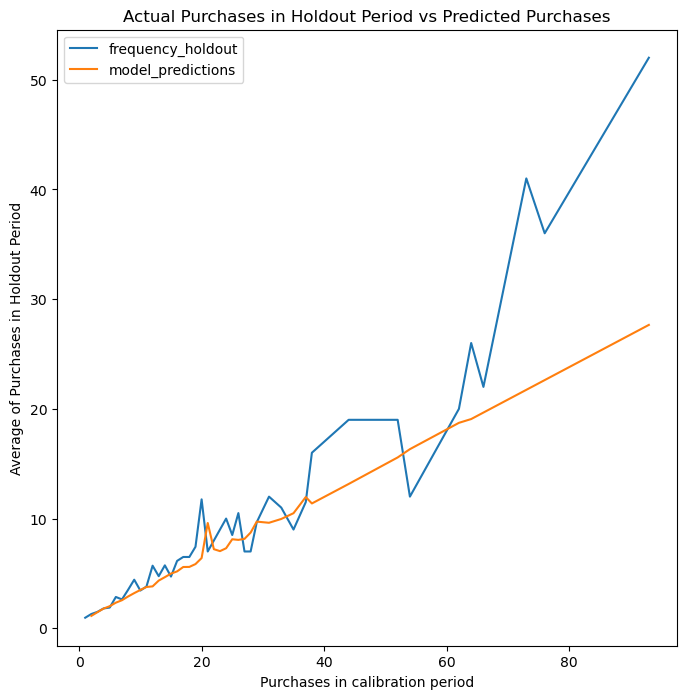

In [43]:
# Visualize Predicted vs. Actual Purchases in Holdout Period

plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_pd, 
  n=90, 
  **{'figsize':(8,8)}
  )
  


What we see here is that a higher frequency of purchase predicts in the calibration period predicts a higher frequency of purchases in the holdout period. For customers with lower frequencies, the correlation is pretty reliable. For customers with higher frequencies, the model tends to be a bit more conservative and underestimates purchases in that period. Some of that may have to do with the fact that a 90-day holdout ending on Dec 9 would be intersecting with the traditional holiday shopping period within which most consumers make a higher than normal number of purchases. Ideally, we'd employ multiple years of data and find a holdout period that's a little more middle-of-the-road than something in that specific period.

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 57, Finished, Available)

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Time since user made last purchase', ylabel='Average of Purchases in Holdout Period'>

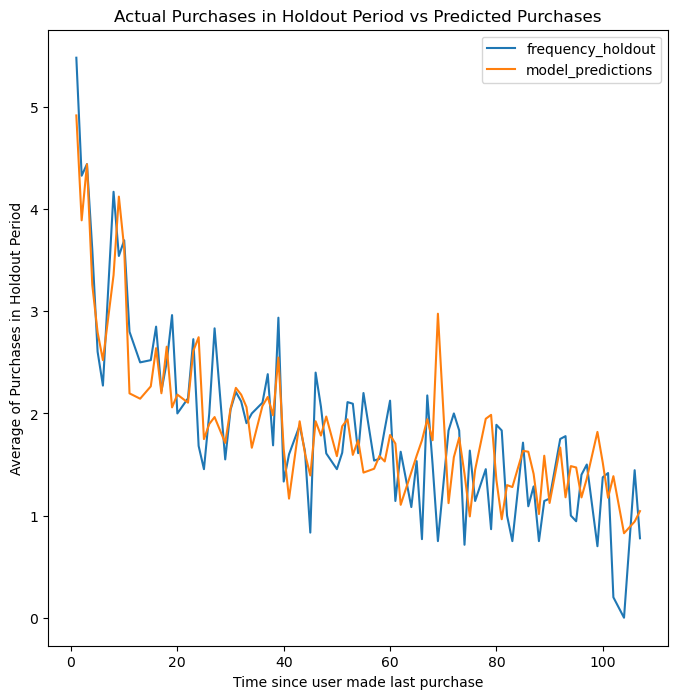

In [44]:
# Visualize Purchase Frequency vs. Actual Purchases in Holdout Period
plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_pd, 
  kind='time_since_last_purchase', 
  n=90, 
  **{'figsize':(8,8)}
  )

Plugging the age of the customer at the time of the last purchase into the chart shows that the timing of the last purchase in a customer's lifecycle doesn't seem to have a strong influence on the number of purchases in the holdout period until a customer becomes quite old. This would indicate that the customers that stick around a long while are likely to be more frequently engaged:

NOTE As a reminder, age is also known as term and refers to the number of periods (days) since a customer's first purchase.

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 58, Finished, Available)

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Age of customer at last purchase', ylabel='Average of Purchases in Holdout Period'>

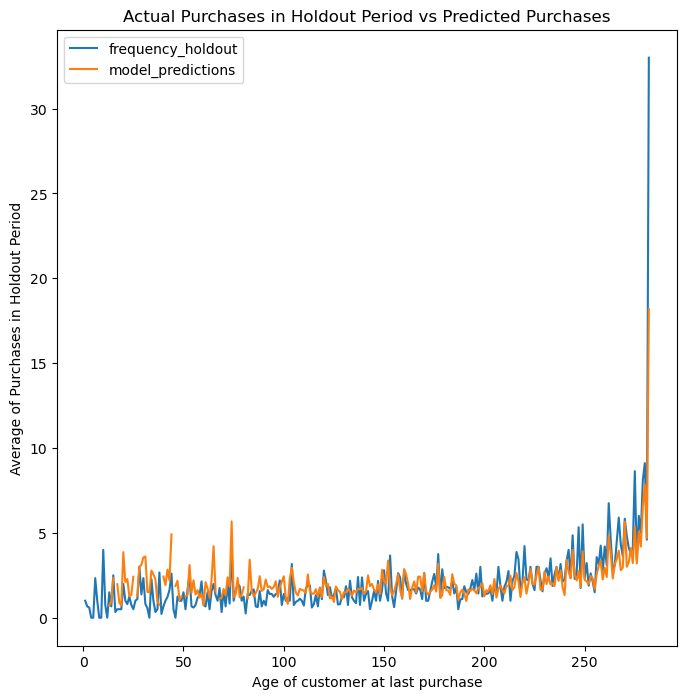

In [45]:
# Visualize Customer Age (Term) vs. Purchases in Holdout Period
plot_calibration_purchases_vs_holdout_purchases(
  bgf_engagement, 
  input_pd, 
  kind='recency_cal', 
  n=300,
  **{'figsize':(8,8)}
  )
 

From a quick visual inspection, it's fair to say our model isn't perfect but there are some useful patterns that it captures. Using these patterns, we might calculate the probability a customer remains engaged:

In [46]:
# Estimate Probability Customer is Retained
# add a field with the probability a customer is currently "alive"
filtered_pd['prob_alive']=bgf_engagement.conditional_probability_alive(
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
 
filtered_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 59, Finished, Available)

,frequency,recency,T,monetary_value,prob_alive
CustomerID,,,,,
12347,6.0,365.0,367.0,599.701667,1.0
12348,3.0,283.0,358.0,301.480000,1.0
12352,6.0,260.0,296.0,208.151667,1.0
12356,2.0,303.0,325.0,269.905000,1.0
12358,1.0,149.0,150.0,683.200000,1.0
12359,5.0,324.0,331.0,1139.606000,1.0
12360,2.0,148.0,200.0,789.240000,1.0
12362,12.0,292.0,295.0,389.623333,1.0
12363,1.0,133.0,242.0,252.900000,1.0


The model derives whether customer will staying engaged/alive and derives probabilities of the customers re-engaging by looking at the history of a individual customer transactions.

The exact math of how these probabilities are derived is tricky but by plotting the probability of being alive as a heatmap relative to frequency and recency, we can understand the probabilities assigned to the intersections of these two values:

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 60, Finished, Available)

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

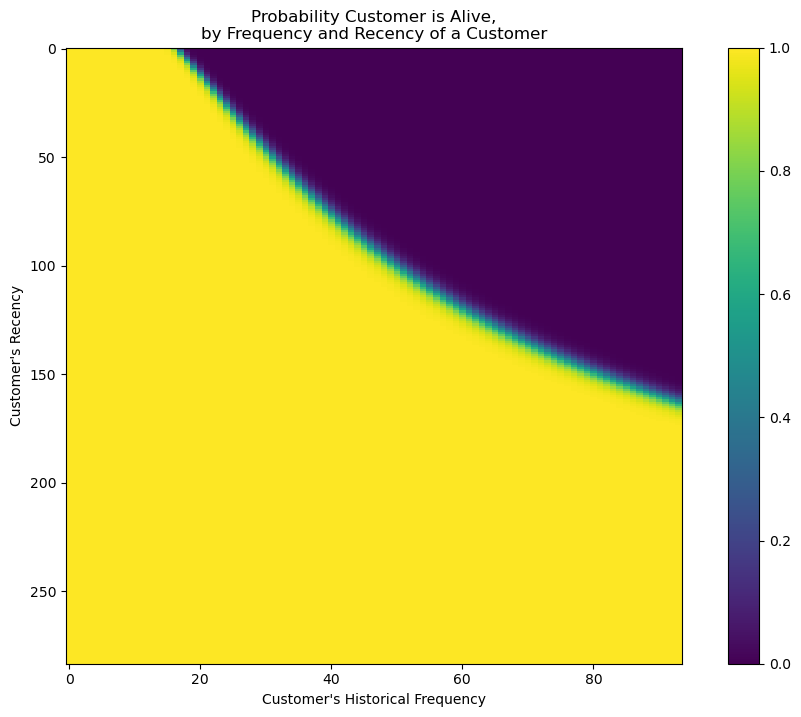

In [47]:
# Visualize Relationship Between Recency, Frequency & Probability of Retention
# set figure size
plt.subplots(figsize=(12, 8))
 
plot_probability_alive_matrix(bgf_engagement) 

In addition to predicting the probability a customer is still alive, we can calculate the number of purchases expected from a customer over a given future time interval, such as over the next 30-days:

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 61, Finished, Available)

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

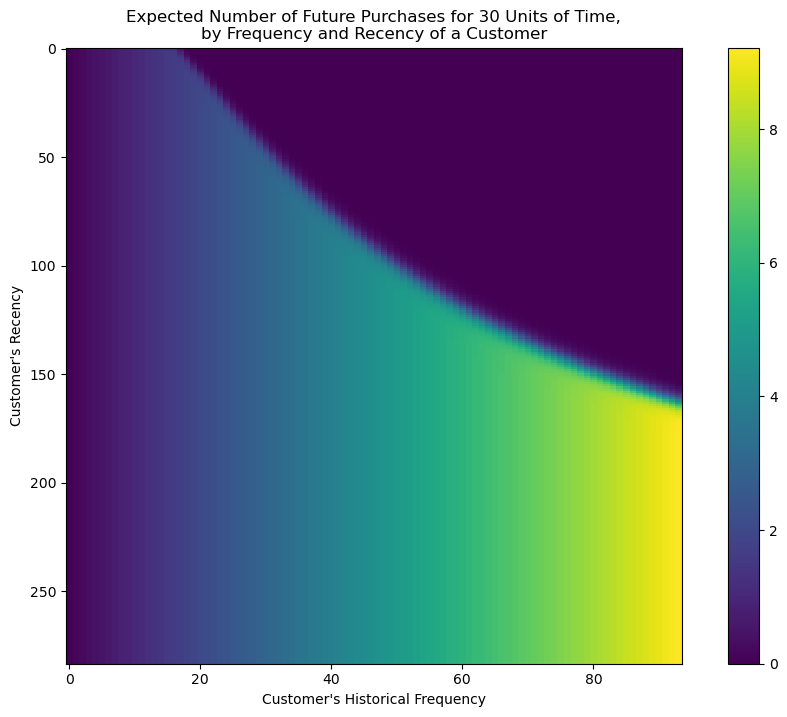

In [48]:
# Visualize Relationship Between Recency, Frequency & Expected Purchases within a Time Span
# set figure size
plt.subplots(figsize=(12, 8))
 
plot_frequency_recency_matrix(bgf_engagement, T=30) 

As before, we can calculate this probability for each customer based on their current metrics:

In [49]:
# Estimate Number of Purchases within a Time Span
filtered_pd['purchases_next30days']=(
  bgf_engagement.conditional_expected_number_of_purchases_up_to_time(
    30, 
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
  )
 
filtered_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 62, Finished, Available)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
CustomerID,,,,,,
12347,6.0,365.0,367.0,599.701667,1.0,0.498875
12348,3.0,283.0,358.0,301.480000,1.0,0.273368
12352,6.0,260.0,296.0,208.151667,1.0,0.610542
12356,2.0,303.0,325.0,269.905000,1.0,0.212769
12358,1.0,149.0,150.0,683.200000,1.0,0.255029
12359,5.0,324.0,331.0,1139.606000,1.0,0.464687
12360,2.0,148.0,200.0,789.240000,1.0,0.333009
12362,12.0,292.0,295.0,389.623333,1.0,1.181749
12363,1.0,133.0,242.0,252.900000,1.0,0.165882


There are numerous ways we might make use of the trained BTYD model.

* We may wish to understand the probability a customer is still engaged.
* We may also wish to predict the number of purchases expected from the customer over some number of days.
All we need to make these predictions is our trained model and values of frequency, recency and age (T) for the customer.

# Step 5: Train the Customer Spend Model
The BetaGeo model provides us with the ability to predict a customer's retention into a future period. The [GammaGamma model](http://www.brucehardie.com/notes/025/gamma_gamma.pdf) (named for the two gamma distributions is estimates) is used to estimate the monetary value of the spend in those periods. A key assumption of the GammaGamma model is that a customer's purchase frequency does not affect the monetary value of their spend. We can test this quickly with simply correlation calculation:

In [50]:
# EXAMINE CORRELATIO NBETWEEN FREQUENCY & MONETARY VALUE
filtered.corr('frequency', 'monetary_value')

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 63, Finished, Available)

0.1749838427915169

We can now fit our GammaGamma model:

In [52]:
# TRIAN GAMMAGAMMA MODEL
# instantiate and configure model
ggm_spend = GammaGammaFitter(penalizer_coef=0.002)

ggm_training_data = filtered_cal.toPandas()
print(ggm_training_data.columns)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 65, Finished, Available)

Index(['customerid', 'frequency_cal', 'recency_cal', 'T_cal',
       'monetary_value_cal', 'frequency_holdout', 'monetary_value_holdout',
       'duration_holdout'],
      dtype='object')


In [53]:
# fit the model
ggm_spend.fit(ggm_training_data['frequency_cal'], ggm_training_data['monetary_value_cal'])

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 66, Finished, Available)

<btyd.GammaGammaFitter: fitted with 1965 subjects, p: 5.487529708745184, q: 0.5674951425380368, v: 8.472677982890435>

The evaluation of the spend model is fairly straightforward. We might examine how well predicted values align with actuals in the holdout period and derive an RMSE from it:

In [55]:
# evaluate the model
monetary_actual = input_pd['monetary_value_holdout']
monetary_predicted = ggm_spend.conditional_expected_average_profit(input_pd['frequency_holdout'], input_pd['monetary_value_holdout'])
mse = score_model(monetary_actual, monetary_predicted, 'rmse')
print('RMSE: {0}'.format(mse))

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 68, Finished, Available)

RMSE: 64.99470265521916


We might also visually inspect how are predicted spend values align with actuals, a technique employed in the original paper that described the Gamma-Gamma model:

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 69, Finished, Available)

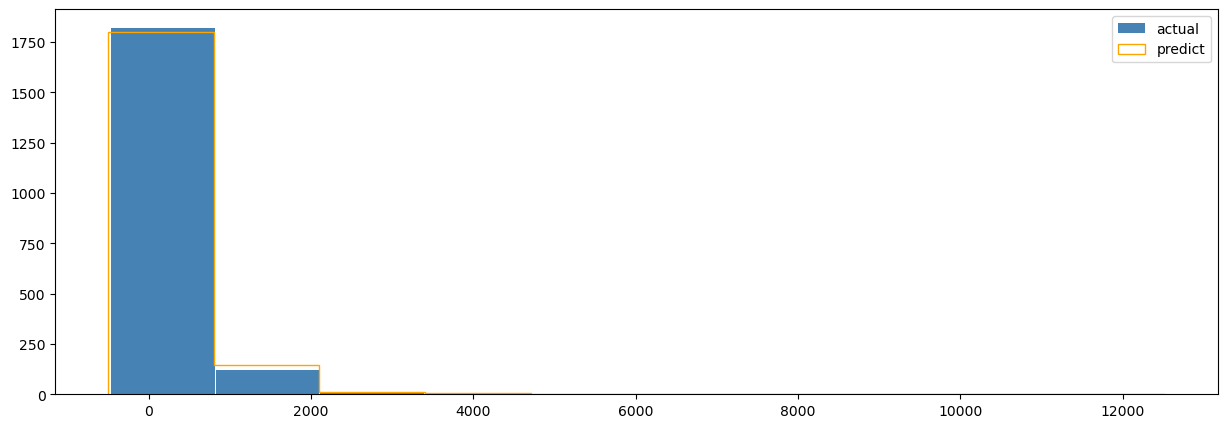

In [56]:
# COMPARE HISTOGRAMS FOR ACTUAL & PREDICTED SPEND

# define histogram bin count
bins = 10
 
# plot size
plt.figure(figsize=(15, 5))
 
# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
 
# place legend on chart
plt.legend(loc='upper right')

With only 10 bins, our model looks like it lines up with our actuals data pretty nicely. If we expand the bin count, we see that the model underpredicts the occurrence of the lowest valued spend while following the remaining structure of the data. Interestingly, a similar pattern was observed in the original paper cited earlier:

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 70, Finished, Available)

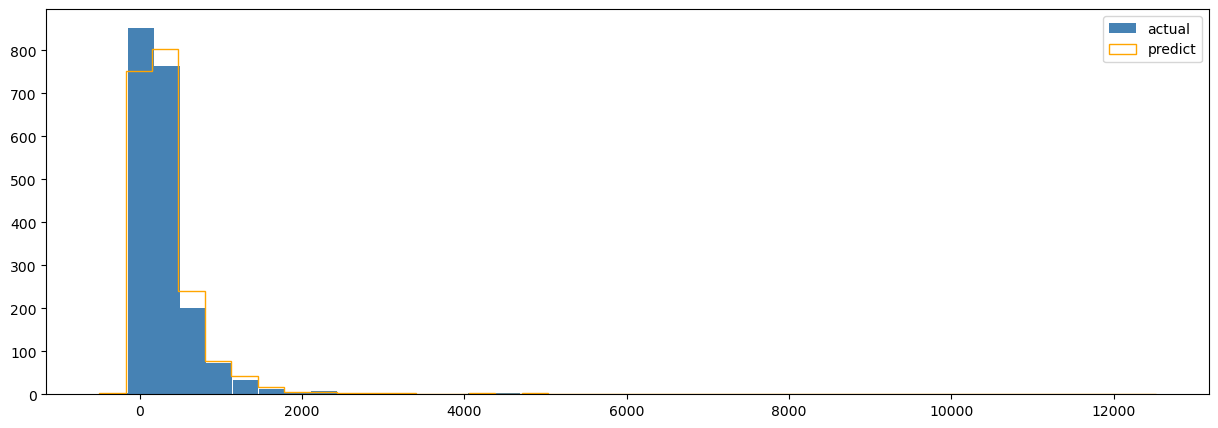

In [57]:
# COMPARE HISTOGRAMS FOR ACTUAL & PREDICTED SPEND WITH HIGHER BIN COUNT
# define histogram bin count
bins = 40
 
# plot size
plt.figure(figsize=(15, 5))
 
# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
 
# place legend on chart
plt.legend(loc='upper right')

# Step 6: Calculate Customer Lifetime Value
Using our two models, we can now estimate the probability a customer will be retained into a future period as well the amount they are likely to spend in that period, providing us the basis for a customer lifetime value estimation. The btyd library provides some built-in functionality for this that simplifies the calculation.

Please note that we are estimating CLV for only a 12-month period given the limited data inputs available to us. We are also using a monthly discount rate of 1%. If you only have access to an annual discount rate, be sure to convert it to monthly using [this formula](https://www.experiglot.com/2006/06/07/how-to-convert-from-an-annual-rate-to-an-effective-periodic-rate-javascript-calculator/).

In [58]:
# CALCULATE 12-MONTH CLV
clv_input_pd = filtered.toPandas()
 
# calculate the 1-year CLV for each customer
clv_input_pd['clv'] = (
  ggm_spend.customer_lifetime_value(
    bgf_engagement, #the model to use to predict the number of future transactions
    clv_input_pd['frequency'],
    clv_input_pd['recency'],
    clv_input_pd['T'],
    clv_input_pd['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
  )
)
 
clv_input_pd.head(10)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 71, Finished, Available)

,customerid,frequency,recency,T,monetary_value,clv
0,12347,6.0,365.0,367.0,599.701667,3420.099045
1,12348,3.0,283.0,358.0,301.480000,961.538517
2,12352,6.0,260.0,296.0,208.151667,1459.227097
3,12356,2.0,303.0,325.0,269.905000,683.427525
4,12358,1.0,149.0,150.0,683.200000,NaN
5,12359,5.0,324.0,331.0,1139.606000,6064.700068
6,12360,2.0,148.0,200.0,789.240000,3095.991766
7,12362,12.0,292.0,295.0,389.623333,5225.964898
8,12363,1.0,133.0,242.0,252.900000,NaN
9,12364,3.0,105.0,112.0,229.726667,2091.985187


CLV is a powerful metric used by organizations to plan targeted promotional activities and assess customer equity. As such, it would be very helpful if we could convert our models into an easy to use function which we could employ in batch, streaming and interactive scenarios.

To help us package our models for deployment, we'll save the BetaGeo model to a temporary path. This is necessary because we will import the saved model as an artifact tied to our GammaGamma model within MLflow. It doesn't really matter which we save so long as we remember which is the primary model and which must be retrieved from the model artifacts when we write our custom pyfunc model wrapper (in the next cell):

In [62]:
# PERSIST THE BETAGEO MODEL
# locatio nto save temp copy of btyd model
CEP_model_path = "abfss://f7a2eb39-d18b-4f3c-8fc3-db8793d2497e@onelake.dfs.fabric.microsoft.com/8f222967-5183-4e01-a5d7-886069878aff/Files/online_retail/customer_engagement_model.pkl"

# delete any prior copies that may exist
try:
    mssparkutils.fs.rm(CEP_model_path)
except:
    pass



StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 75, Finished, Available)

In [63]:
# save the model to the temp location
bgf_engagement.save_model(CEP_model_path)

StatementMeta(, 033caa46-0d75-4516-8444-f3f157e70507, 76, Finished, Available)

FileNotFoundError: [Errno 2] No such file or directory: 'abfss://f7a2eb39-d18b-4f3c-8fc3-db8793d2497e@onelake.dfs.fabric.microsoft.com/8f222967-5183-4e01-a5d7-886069878aff/Files/online_retail/customer_engagement_model.pkl'

Now, let's define the custom wrapper for our spend model. The challenge now is to package our spend model into something we could re-use for this purpose. As a platform, mlflow is designed to solve a wide range of challenges that come with model development and deployment, including the deployment of models as functions and microservice applications.

MLFlow tackles deployment challenges out of the box for a number of [popular model types](https://www.mlflow.org/docs/latest/models.html#built-in-model-flavors). However, btyd models are not one of these. To use mlflow as our deployment vehicle, we need to write a custom wrapper class which translates the standard mlflow API calls into logic which can be applied against our model.

To illustrate this, we've implemented a wrapper class for our btyd model which maps the mlflow predict() method to multiple prediction calls against our model. Notice that the predict() method is fairly simple and returns just a CLV value. Notice too that it assumes a consistent value for month and discount rate is provided in the incoming data.

Besides modification to the predict() method logic, a new definition for load_context() is provided. This method is called when an mlflow model is instantiated. In it, we will load our btyd model artifact: